<center>
  <b><font size=6.5 face="Times">
    CNN_Sorghum_Weed_Classifier
  </font></b><br/>
  <font size=4 face="brush script"><i>
    An AI-based Software for Pre-processing and Experimenting 'SorghumWeedDataset_Classification' dataset in Python
  </i></font>
</center>

<font face="cursive">
  <h6>Related references:</h6>
  <a href="https://github.com/JustinaMichael/CNN_Sorghum-Weed_Classifier.git">GitHub repository for source code</a> <br/>
  <a href="https://github.com/JustinaMichael/SorghumWeedDataset_Classification.git">GitHub repository for dataset</a> <br/>
  <a href="https://data.mendeley.com/datasets/4gkcyxjyss/1">Mendeley data repository for dataset(First appeared) </a>
</font>

<font face="monospace">
  <h6>Contributors profile:</h6>
  <a href="https://scholar.google.com/citations?user=pEEzO14AAAAJ&hl=en&oi=ao">Justina Michael. J<a/>
  <a href="https://scholar.google.com/citations?user=Es49w08AAAAJ&hl=en&oi=ao">Dr. M. Thenmozhi<a/>
</font>

### Cloning the 'SorghumWeedDataset_Classification' dataset from GitHub repository

In [1]:
!git clone https://github.com/JustinaMichael/SorghumWeedDataset_Classification.git

Cloning into 'SorghumWeedDataset_Classification'...
remote: Enumerating objects: 4336, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 4336 (delta 2), reused 5 (delta 0), pack-reused 4326
Receiving objects: 100% (4336/4336), 63.63 MiB | 12.80 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Data Pre-processing
### Importing necessary libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
import itertools
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np, cv2
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numpy import expand_dims
from google.colab.patches import cv2_imshow
from skimage.io import imsave

### Variable declaration

In [3]:
# Setting training, validation, and testing paths
root_path = r"/content/SorghumWeedDataset_Classification"
train_path=root_path+'/Train/'
validation_path=root_path+'/Validate/'
test_path=root_path+'/Test/'

# Finding total number of classes
num_classes = len(glob(test_path + '/*'))

# Random seed setting to inititalize same random weights every time when we build the model
tf.random.set_seed(0)

### Initializing tuned hyper-parameter values

In [4]:
# Declaring the number of epochs
epochs = 50

# Image resize
img_size = 224

# Decalring batch size
batch_size = 32

# Class mode for data augmentation
class_mode = 'categorical'

# Declaring learning rate
my_learning_rate = .001

# Declaring the model loss funtion
loss = 'categorical_crossentropy'

# Activation function
activation = 'softmax'

# URL of the single image from test data
single_image_path = r"/content/SorghumWeedDataset_Classification/Test/Class0_Sorghum/SorghumTest (1).jpeg"

### Data Augmentation and Data Normalization

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 45,
                                       width_shift_range = 0.3,
                                       shear_range = 0.25,
                                       zoom_range = 0.25,
                                       height_shift_range = 0.3,
                                       horizontal_flip = True,
                                       brightness_range=(0.2, 0.9),
                                       vertical_flip = True,
                                       fill_mode = 'reflect')
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
# Augmenting and normalizing the training images
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (img_size, img_size),
                                                 batch_size = batch_size,
                                                 class_mode = class_mode)

Found 3019 images belonging to 3 classes.


In [7]:
# Normalizing the validating images
valid_set = valid_datagen.flow_from_directory(validation_path,
                                            target_size = (img_size, img_size),
                                            batch_size = batch_size,
                                            class_mode = class_mode)

Found 862 images belonging to 3 classes.


In [8]:
# Normalizing the testing images
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (img_size, img_size),
                                            batch_size = batch_size,
                                            class_mode = class_mode)

Found 431 images belonging to 3 classes.


#### Knowing the model parameter and hyper-parameter values

In [9]:
# Training step
training_step = len(training_set)*batch_size
print("Training details:")
print("\t Steps per epoch \\ Number of iterations \\ Number of batches = ", len(training_set))
print("\t Batch size = ", batch_size)
print("\t Number of steps = ", training_step)

# Validation step
validation_step = len(valid_set)*batch_size
print("Validation details:")
print("\t Validation steps = ", len(valid_set))
print("\t Batch size = ", batch_size)

Training details:
	 Steps per epoch \ Number of iterations \ Number of batches =  95
	 Batch size =  32
	 Number of steps =  3040
Validation details:
	 Validation steps =  27
	 Batch size =  32


<center> <h2> <b> Building Model I </b> </h2> </center>

### Building and training the VGG19 model

In [10]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

# Adding preprocessing layer to the front
vgg19 = VGG19(input_shape=[img_size, img_size] + [3], weights='imagenet', include_top=False)

# Not training existing weights
for layer in vgg19.layers:
    layer.trainable = False

# This model's layers [could be extended]
x = Flatten()(vgg19.output)

# Dense layer
prediction = Dense(units=num_classes, activation=activation, kernel_initializer="glorot_uniform")(x)

# Creating a model object
model = Model(inputs=vgg19.input, outputs=prediction)

# Printing the model summary
model.summary()

# Model cost optimization
model.compile(optimizer = Adam(learning_rate=my_learning_rate),
              loss = loss,
              metrics = ['accuracy'],
              steps_per_execution = 1)

# Early stopping and model check point
es = EarlyStopping(monitor = "val_accuracy",
                   min_delta = 0.01,
                   patience = 5,
                   verbose = 1,
                   mode = 'auto')
mc = ModelCheckpoint(monitor = "val_accuracy",
                     filepath = root_path + '/vgg19.h5' ,
                     verbose = 1,
                     save_best_only = True,
                     mode = 'auto')
cd = [es, mc]

# Training the model
# NOTE: Training the model may produce slight variations in the result
history = model.fit(
  x = training_set,
  batch_size = batch_size,
  epochs = epochs,
  callbacks = cd,
  validation_data = valid_set,
  steps_per_epoch = len(training_set),
  validation_steps = len(valid_set),
  validation_batch_size = batch_size,
  validation_freq = 1
)


80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 71s 605ms/step - loss: 0.7190 - accuracy: 0.7423 - val_loss: 0.4557 - val_accuracy: 0.8202
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.8665
Epoch 2: val_accuracy improved from 0.82019 to 0.87587, saving model to /content/SorghumWeedDataset_Classification/vgg19.h5
95/95 [==============================] - 54s 568ms/step - loss: 0.3530 - accuracy: 0.8665 - val_loss: 0.3123 - val_accuracy: 0.8759
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.3336 - accuracy: 0.8599
Epoch 3: val_accuracy improved from 0.87587 to 0.90023, saving model to /content/SorghumWeedDataset_Classification/vgg19.h5
95/95 [==============================] - 55s 578ms/step - loss: 0.3336 - accuracy: 0.8599 - val_loss: 0.2444 - val_accuracy: 0.9002
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.8874
Epoch 4: val_accuracy improved from 0.90023 to 0.90603, saving model to /c

### Training\\Validation Accuracy\\loss

Training Loss:  0.26759105920791626
Training Accuracy:  0.8983107209205627
Validation Loss:  0.20193950831890106
Validation Accuracy:  0.936194896697998


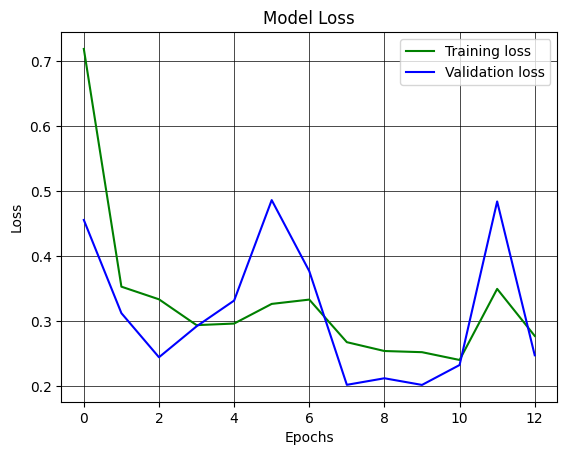

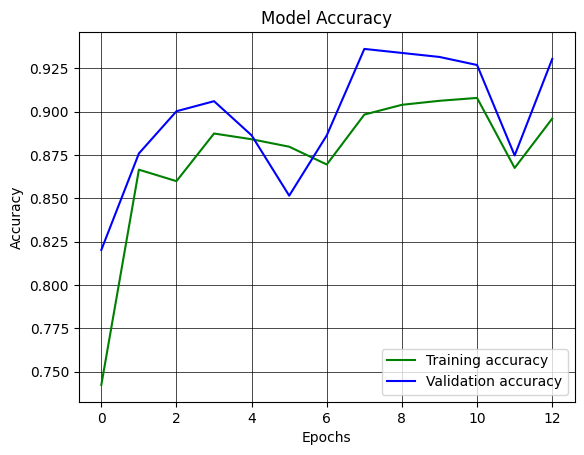

In [11]:
#Finding the maximum validation accuracy and its respective metrics
vgg19_max_val_acc = max(history.history['val_accuracy'])
vgg19_indices = [index for index, value in enumerate(history.history['val_accuracy']) if value == vgg19_max_val_acc]
vgg19_index_max_val_acc = vgg19_indices[0]
vgg19_max_training_loss = history.history['loss'][vgg19_index_max_val_acc]
vgg19_max_training_accuracy = history.history['accuracy'][vgg19_index_max_val_acc]
vgg19_max_validation_loss = history.history['val_loss'][vgg19_index_max_val_acc]

#Printing all metrics
print("Training Loss: ", vgg19_max_training_loss)
print("Training Accuracy: ", vgg19_max_training_accuracy)
print("Validation Loss: ", vgg19_max_validation_loss)
print("Validation Accuracy: ", vgg19_max_val_acc)

#Train loss vs validation loss graph
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#Train accuracy vs validation accuracy graph
plt.plot(history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### Evaluating the model with test data

In [12]:
evaluate_test_data = model.evaluate(test_set)
vgg19_test_loss = evaluate_test_data[0]
vgg19_test_acc = evaluate_test_data[1]

print("Testing loss: ", vgg19_test_loss)
print("Testing accuracy: ", vgg19_test_acc)

14/14 [==============================] - 4s 320ms/step - loss: 0.2216 - accuracy: 0.9420
Testing loss:  0.22155122458934784
Testing accuracy:  0.94199538230896


### Loading, analyzing and predicting an image from test data


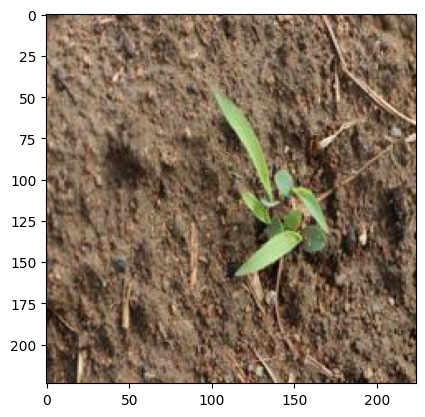

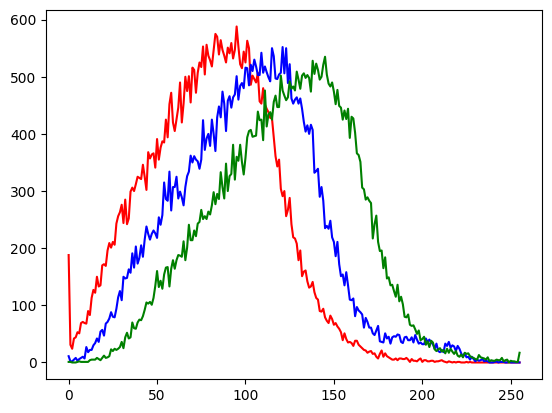

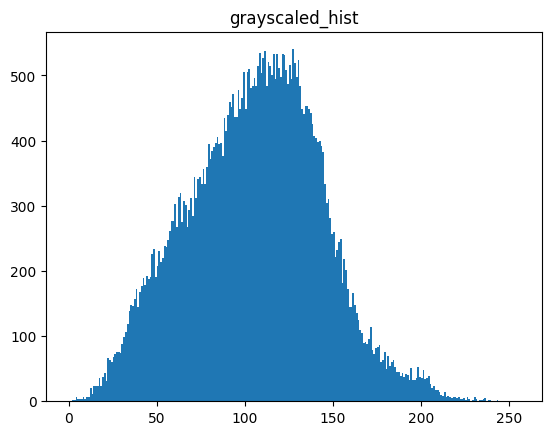

1/1 [==============================] - 1s 650ms/step
Predicted class:  0
Sorghum


In [13]:
# Reading and displaying an image
img = load_img(single_image_path, target_size = (img_size,img_size))
plt.figure(1)
plt.imshow(img)

# Viewing the BGR histogram of the respective image
plt.figure(2)
cv2_img = cv2.imread(single_image_path)
color = {'b', 'g', 'r'}
for i, col in enumerate(color):
  histr = cv2.calcHist(images=[cv2_img],channels=[i],mask=None,histSize=[256], ranges=[0,256])
  plt.plot(histr, color=col)
plt.show()

# Viewing the gray-scaled histogram of the respective image
plt.figure(3)
img_grayscaled = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
plt.hist(img_grayscaled.ravel(), bins=256, range=[0,256])
plt.title('grayscaled_hist')
plt.show()

# Prediction of an image
input_arr = img_to_array(img)/255
input_arr = np.expand_dims(input_arr, axis = 0)
predictions = np.argmax(model.predict(input_arr), axis = -1)[0]
print("Predicted class: ", predictions)
print("Sorghum") if predictions == 0 else print("Grass weeds") if predictions == 1 else print("Broadleaf weeds")

### Predicting the classes of test data

In [14]:
# Declaring y_test
y_test= test_set.classes

# Finding the total number of test images
len_test_set = 0
for root, dirs, files in (os.walk(test_path)):
    for name in (files):
        len_test_set = len_test_set + 1

# Image prediction
y_pred = np.empty([len_test_set,1])
count = 0
for root, dirs, files in sorted(os.walk(test_path)):
    for name in sorted(files):
        img_path = os.path.join(root, name)
        img = load_img(img_path, target_size = (img_size,img_size))
        input_arr = img_to_array(img)/255
        input_arr = np.expand_dims(input_arr, axis = 0)
        y_pred[count] = np.argmax(model.predict(input_arr), axis = -1)[0]
        count = count + 1

1/1 [==============================] - 0s 18ms/step


### Generating classification report and confusion matrix for test data

CLASSIFICATION REPORT OF SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS
              precision    recall  f1-score   support

     class 0     0.8750    1.0000    0.9333       140
     class 1     0.9624    0.8707    0.9143       147
     class 2     1.0000    0.9583    0.9787       144

    accuracy                         0.9420       431
   macro avg     0.9458    0.9430    0.9421       431
weighted avg     0.9466    0.9420    0.9420       431



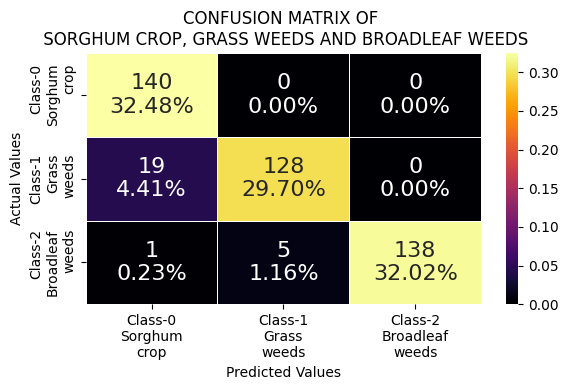

In [15]:
# Generating classification report
target_names = ['class 0', 'class 1', 'class 2']
print('CLASSIFICATION REPORT OF SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# Generating confusion matrix
cm_type = confusion_matrix(y_test, y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in cm_type.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm_type.flatten()/np.sum(cm_type)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(num_classes,num_classes)
figure = plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_type/np.sum(cm_type), annot=labels, fmt='', cmap='inferno', annot_kws={"size": 16}, linecolor='white', linewidths=0.7)
ax.set_title('CONFUSION MATRIX OF \n SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
ax.yaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
plt.tight_layout()
plt.show()

<center> <h2> <b> Building Model II </b> </h2> </center>

### Building and training the DenseNet201 model

In [16]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

# Adding preprocessing layer to the front
densenet201 = DenseNet201(input_shape=[img_size, img_size] + [3], weights='imagenet', include_top=False)

# Not training existing weights
for layer in densenet201.layers:
    layer.trainable = False

# This model's layers [could be extended]
x = Flatten()(densenet201.output)

# Dense layer
prediction = Dense(num_classes, activation=activation)(x)

# Creating a model object
model = Model(inputs=densenet201.input, outputs=prediction)

# Printing the model summary
model.summary()

# Model cost optimization
model.compile(Adam(learning_rate=my_learning_rate), loss=loss, metrics=['accuracy'])

# Early stopping and model check point
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor = "val_accuracy", filepath = root_path + '/densenet201.h5' , verbose = 1, save_best_only = True, mode = 'auto')
cd = [es, mc]

# Training the model
# NOTE: Training the model may produce slight variations in the result
history = model.fit(
  x = training_set,
  batch_size = batch_size,
  epochs = epochs,
  callbacks = cd,
  validation_data = valid_set,
  steps_per_epoch = len(training_set),
  validation_steps = len(valid_set),
  validation_batch_size = batch_size,
  validation_freq = 1
)


74836368/74836368 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 81s 684ms/step - loss: 0.3314 - accuracy: 0.9145 - val_loss: 0.6299 - val_accuracy: 0.9118
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.2934 - accuracy: 0.9450
Epoch 2: val_accuracy did not improve from 0.91183
95/95 [==============================] - 53s 556ms/step - loss: 0.2934 - accuracy: 0.9450 - val_loss: 1.2920 - val_accuracy: 0.8933
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.9556
Epoch 3: val_accuracy improved from 0.91183 to 0.94084, saving model to /content/SorghumWeedDataset_Classification/densenet201.h5
95/95 [==============================] - 56s 589ms/step - loss: 0.2713 - accuracy: 0.9556 - val_loss: 0.5174 - val_accuracy: 0.9408
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 0.2428 - accuracy: 0.9593
Epoch 4: val_accuracy improved from 0.94084 to 0.94780, saving model to /content/SorghumWeedDataset_Classification/densenet201.h5
95/95 [====

### Training\\Validation Accuracy\\loss

Training Loss:  0.22285477817058563
Training Accuracy:  0.9685326218605042
Validation Loss:  0.7697639465332031
Validation Accuracy:  0.9582366347312927


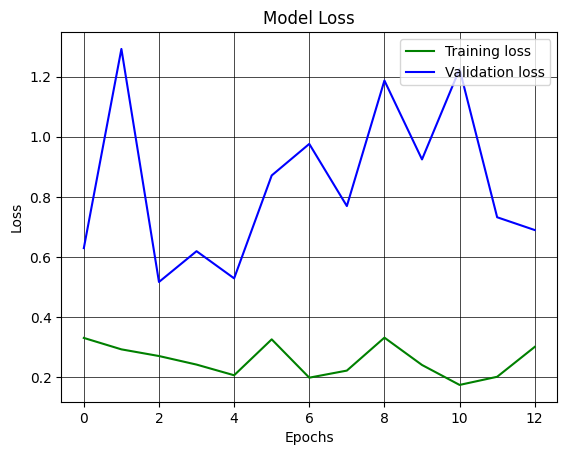

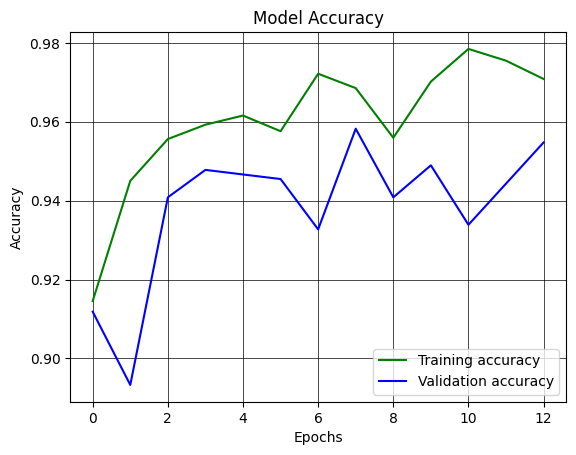

In [17]:
#Finding the maximum validation accuracy and its respective metrics
densenet201_max_val_acc = max(history.history['val_accuracy'])
densenet201_indices = [index for index, value in enumerate(history.history['val_accuracy']) if value == densenet201_max_val_acc]
densenet201_index_max_val_acc = densenet201_indices[0]
densenet201_max_training_loss = history.history['loss'][densenet201_index_max_val_acc]
densenet201_max_training_accuracy = history.history['accuracy'][densenet201_index_max_val_acc]
densenet201_max_validation_loss = history.history['val_loss'][densenet201_index_max_val_acc]

#Printing all metrics
print("Training Loss: ", densenet201_max_training_loss)
print("Training Accuracy: ", densenet201_max_training_accuracy)
print("Validation Loss: ", densenet201_max_validation_loss)
print("Validation Accuracy: ", densenet201_max_val_acc)

#Train loss vs validation loss graph
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#Train accuracy vs validation accuracy graph
plt.plot(history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### Evaluating the model with test data

In [18]:
evaluate_test_data = model.evaluate(test_set)
densenet201_test_loss = evaluate_test_data[0]
densenet201_test_acc = evaluate_test_data[1]

print("Testing loss: ", densenet201_test_loss)
print("Testing accuracy: ", densenet201_test_acc)

14/14 [==============================] - 5s 341ms/step - loss: 0.4414 - accuracy: 0.9606
Testing loss:  0.4413609206676483
Testing accuracy:  0.9605568647384644


### Loading, analyzing and predicting an image from test data


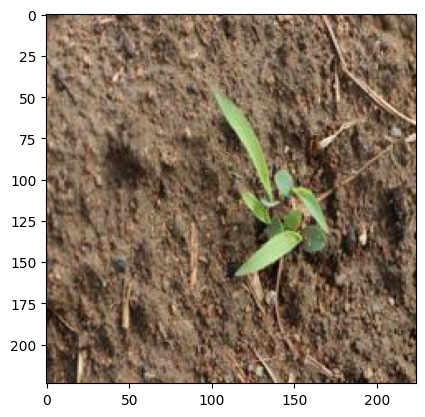

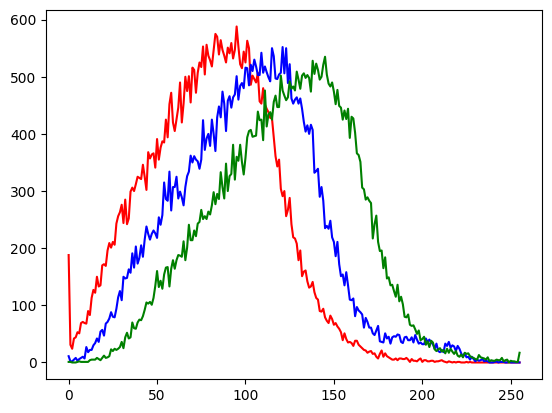

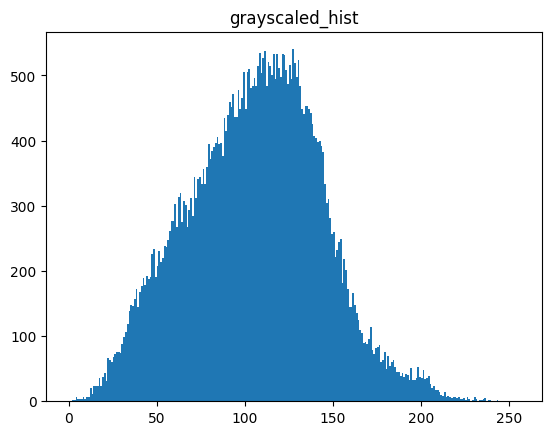

1/1 [==============================] - 5s 5s/step
Predicted class:  0
Sorghum


In [19]:
# Reading and displaying an image
img = load_img(single_image_path, target_size = (img_size,img_size))
plt.figure(1)
plt.imshow(img)

# Viewing the BGR histogram of the respective image
plt.figure(2)
cv2_img = cv2.imread(single_image_path)
color = {'b', 'g', 'r'}
for i, col in enumerate(color):
  histr = cv2.calcHist(images=[cv2_img],channels=[i],mask=None,histSize=[256], ranges=[0,256])
  plt.plot(histr, color=col)
plt.show()

# Viewing the gray-scaled histogram of the respective image
plt.figure(3)
img_grayscaled = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
plt.hist(img_grayscaled.ravel(), bins=256, range=[0,256])
plt.title('grayscaled_hist')
plt.show()

# Prediction of an image
input_arr = img_to_array(img)/255
input_arr = np.expand_dims(input_arr, axis = 0)
predictions = np.argmax(model.predict(input_arr), axis = -1)[0]
print("Predicted class: ", predictions)
print("Sorghum") if predictions == 0 else print("Grass weeds") if predictions == 1 else print("Broadleaf weeds")

### Predicting the classes of test data

In [20]:
# Declaring y_test
y_test= test_set.classes

# Finding the total number of test images
len_test_set = 0
for root, dirs, files in (os.walk(test_path)):
    for name in (files):
        len_test_set = len_test_set + 1

# Image prediction
y_pred = np.empty([len_test_set,1])
count = 0
for root, dirs, files in sorted(os.walk(test_path)):
    for name in sorted(files):
        img_path = os.path.join(root, name)
        img = load_img(img_path, target_size = (img_size,img_size))
        input_arr = img_to_array(img)/255
        input_arr = np.expand_dims(input_arr, axis = 0)
        y_pred[count] = np.argmax(model.predict(input_arr), axis = -1)[0]
        count = count + 1

1/1 [==============================] - 0s 55ms/step


### Generating classification report and confusion matrix for test data

CLASSIFICATION REPORT OF SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS
              precision    recall  f1-score   support

     class 0     0.9507    0.9643    0.9574       140
     class 1     0.9333    0.9524    0.9428       147
     class 2     1.0000    0.9653    0.9823       144

    accuracy                         0.9606       431
   macro avg     0.9613    0.9606    0.9608       431
weighted avg     0.9612    0.9606    0.9608       431



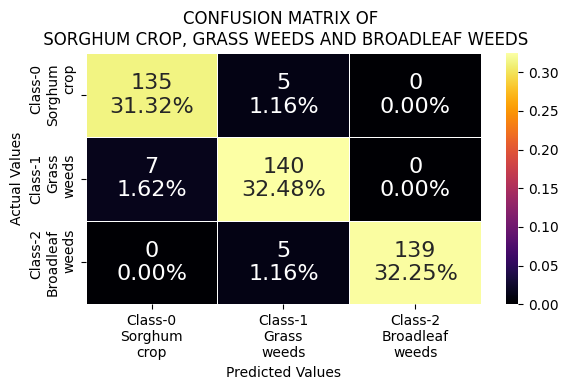

In [21]:
# Generating classification report
target_names = ['class 0', 'class 1', 'class 2']
print('CLASSIFICATION REPORT OF SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# Generating confusion matrix
cm_type = confusion_matrix(y_test, y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in cm_type.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm_type.flatten()/np.sum(cm_type)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(num_classes,num_classes)
figure = plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_type/np.sum(cm_type), annot=labels, fmt='', cmap='inferno', annot_kws={"size": 16}, linecolor='white', linewidths=0.7)
ax.set_title('CONFUSION MATRIX OF \n SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
ax.yaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
plt.tight_layout()
plt.show()

<center> <h2> <b> Building Model III </b> </h2> </center>

### Building the MobileNetV2 model

In [22]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Adding preprocessing layer to the front
mobilenetv2 = MobileNetV2(input_shape=[img_size, img_size] + [3], weights='imagenet', include_top=False)

# Not training existing weights
for layer in mobilenetv2.layers:
    layer.trainable = False

# This model's layers [could be extended]
x = Flatten()(mobilenetv2.output)

# Dense layer
prediction = Dense(num_classes, activation=activation)(x)

# Creating a model object
model = Model(inputs=mobilenetv2.input, outputs=prediction)

# Printing the model summary
model.summary()

# Model cost optimization
model.compile(Adam(learning_rate=my_learning_rate), loss=loss, metrics=['accuracy'])

# Early stopping and model check point
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor = "val_accuracy", filepath = root_path + '/mobilenetv2.h5' , verbose = 1, save_best_only = True, mode = 'auto')
cd = [es, mc]

# Training the model
# NOTE: Training the model may produce slight variations in the result
history = model.fit(
  x = training_set,
  batch_size = batch_size,
  epochs = epochs,
  callbacks = cd,
  validation_data = valid_set,
  steps_per_epoch = len(training_set),
  validation_steps = len(valid_set),
  validation_batch_size = batch_size,
  validation_freq = 1
)


9406464/9406464 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 50s 496ms/step - loss: 1.5478 - accuracy: 0.8721 - val_loss: 1.5315 - val_accuracy: 0.8747
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.5106 - accuracy: 0.9430
Epoch 2: val_accuracy improved from 0.87471 to 0.92459, saving model to /content/SorghumWeedDataset_Classification/mobilenetv2.h5
95/95 [==============================] - 47s 487ms/step - loss: 0.5106 - accuracy: 0.9430 - val_loss: 0.8254 - val_accuracy: 0.9246
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.9480
Epoch 3: val_accuracy did not improve from 0.92459
95/95 [==============================] - 44s 468ms/step - loss: 0.4884 - accuracy: 0.9480 - val_loss: 0.9126 - val_accuracy: 0.9165
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.9450
Epoch 4: val_accuracy improved from 0.92459 to 0.94084, saving model to /content/SorghumWeedDataset_Classification/mobilenetv2.h5
95/95 [====

### Training\\Validation Accuracy\\loss

Training Loss:  0.6925927996635437
Training Accuracy:  0.9562768936157227
Validation Loss:  0.7818799614906311
Validation Accuracy:  0.9593967795372009


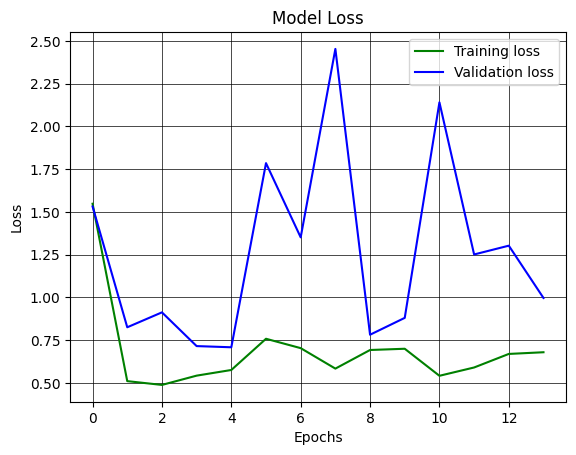

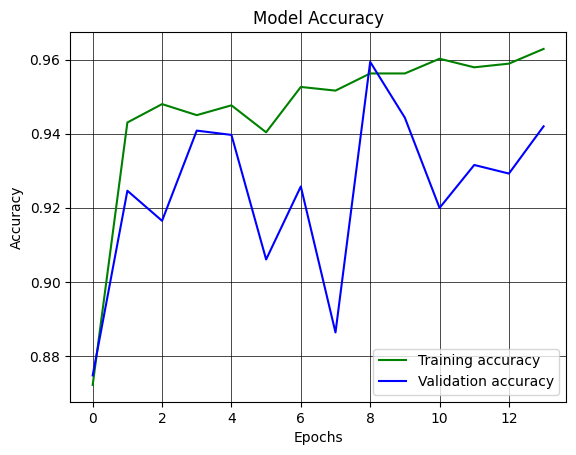

In [23]:
#Finding the maximum validation accuracy and its respective metrics
mobilenetv2_max_val_acc = max(history.history['val_accuracy'])
mobilenetv2_indices = [index for index, value in enumerate(history.history['val_accuracy']) if value == mobilenetv2_max_val_acc]
mobilenetv2_index_max_val_acc = mobilenetv2_indices[0]
mobilenetv2_max_training_loss = history.history['loss'][mobilenetv2_index_max_val_acc]
mobilenetv2_max_training_accuracy = history.history['accuracy'][mobilenetv2_index_max_val_acc]
mobilenetv2_max_validation_loss = history.history['val_loss'][mobilenetv2_index_max_val_acc]

#Printing all metrics
print("Training Loss: ", mobilenetv2_max_training_loss)
print("Training Accuracy: ", mobilenetv2_max_training_accuracy)
print("Validation Loss: ", mobilenetv2_max_validation_loss)
print("Validation Accuracy: ", mobilenetv2_max_val_acc)

#Train loss vs validation loss graph
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#Train accuracy vs validation accuracy graph
plt.plot(history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### Evaluating the model with test data

In [24]:
evaluate_test_data = model.evaluate(test_set)
mobilenetv2_test_loss = evaluate_test_data[0]
mobilenetv2_test_acc = evaluate_test_data[1]

print("Testing loss: ", mobilenetv2_test_loss)
print("Testing accuracy: ", mobilenetv2_test_acc)

14/14 [==============================] - 1s 85ms/step - loss: 1.8539 - accuracy: 0.9188
Testing loss:  1.8539083003997803
Testing accuracy:  0.9187934994697571


### Loading, analyzing and predicting an image from test data


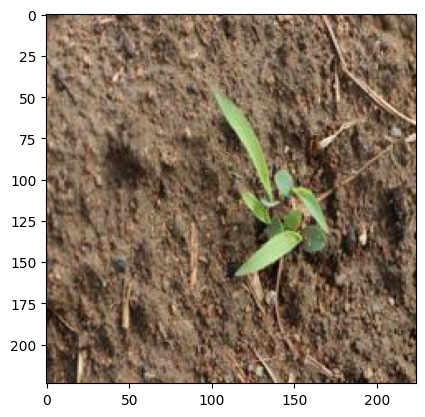

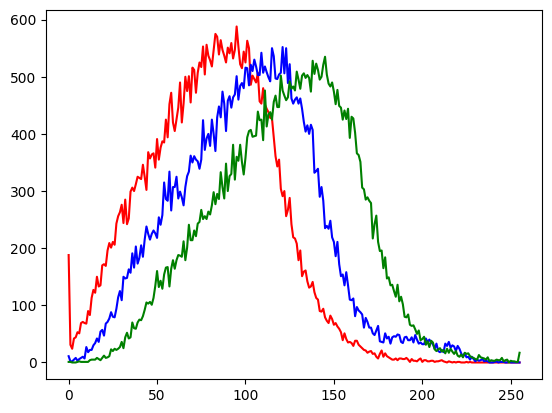

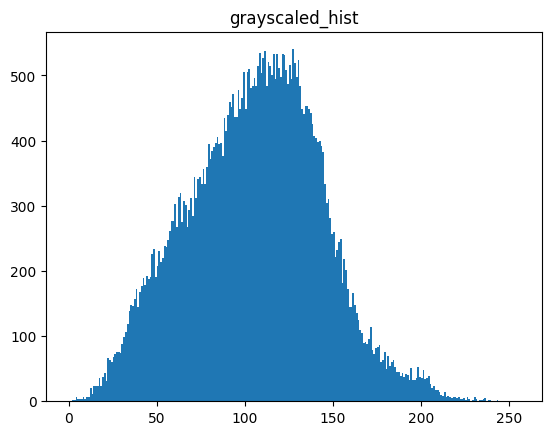

1/1 [==============================] - 1s 1s/step
Predicted class:  0
Sorghum


In [25]:
# Reading and displaying an image
img = load_img(single_image_path, target_size = (img_size,img_size))
plt.figure(1)
plt.imshow(img)

# Viewing the BGR histogram of the respective image
plt.figure(2)
cv2_img = cv2.imread(single_image_path)
color = {'b', 'g', 'r'}
for i, col in enumerate(color):
  histr = cv2.calcHist(images=[cv2_img],channels=[i],mask=None,histSize=[256], ranges=[0,256])
  plt.plot(histr, color=col)
plt.show()

# Viewing the gray-scaled histogram of the respective image
plt.figure(3)
img_grayscaled = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
plt.hist(img_grayscaled.ravel(), bins=256, range=[0,256])
plt.title('grayscaled_hist')
plt.show()

# Prediction of an image
input_arr = img_to_array(img)/255
input_arr = np.expand_dims(input_arr, axis = 0)
predictions = np.argmax(model.predict(input_arr), axis = -1)[0]
print("Predicted class: ", predictions)
print("Sorghum") if predictions == 0 else print("Grass weeds") if predictions == 1 else print("Broadleaf weeds")

### Predicting the classes of test data

In [26]:
# Declaring y_test
y_test= test_set.classes

# Finding the total number of test images
len_test_set = 0
for root, dirs, files in (os.walk(test_path)):
    for name in (files):
        len_test_set = len_test_set + 1

# Image prediction
y_pred = np.empty([len_test_set,1])
count = 0
for root, dirs, files in sorted(os.walk(test_path)):
    for name in sorted(files):
        img_path = os.path.join(root, name)
        img = load_img(img_path, target_size = (img_size,img_size))
        input_arr = img_to_array(img)/255
        input_arr = np.expand_dims(input_arr, axis = 0)
        y_pred[count] = np.argmax(model.predict(input_arr), axis = -1)[0]
        count = count + 1

1/1 [==============================] - 0s 23ms/step


### Generating classification report and confusion matrix for test data

CLASSIFICATION REPORT OF SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS
              precision    recall  f1-score   support

     class 0     0.8690    0.9000    0.8842       140
     class 1     0.8889    0.8707    0.8797       147
     class 2     1.0000    0.9861    0.9930       144

    accuracy                         0.9188       431
   macro avg     0.9193    0.9190    0.9190       431
weighted avg     0.9195    0.9188    0.9190       431



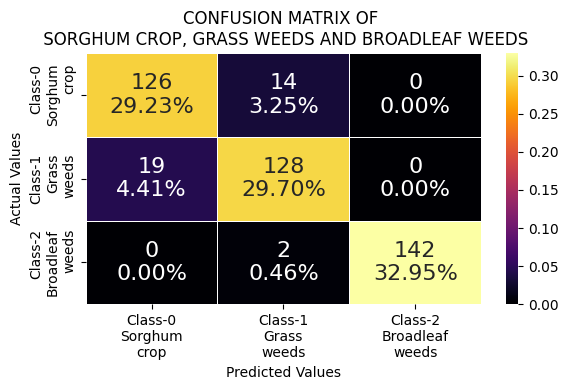

In [27]:
# Generating classification report
target_names = ['class 0', 'class 1', 'class 2']
print('CLASSIFICATION REPORT OF SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# Generating confusion matrix
cm_type = confusion_matrix(y_test, y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in cm_type.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm_type.flatten()/np.sum(cm_type)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(num_classes,num_classes)
figure = plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_type/np.sum(cm_type), annot=labels, fmt='', cmap='inferno', annot_kws={"size": 16}, linecolor='white', linewidths=0.7)
ax.set_title('CONFUSION MATRIX OF \n SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
ax.yaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
plt.tight_layout()
plt.show()

<center> <h2> <b> Building Model IV </b> </h2> </center>

### Building the ResNet152V2 model

In [28]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# Adding preprocessing layer to the front
resnet152v2 = ResNet152V2(input_shape=[img_size, img_size] + [3], weights='imagenet', include_top=False)

# Not training existing weights
for layer in resnet152v2.layers:
    layer.trainable = False

# This model's layers [could be extended]
x = Flatten()(resnet152v2.output)

# Dense layer
prediction = Dense(num_classes, activation=activation, kernel_initializer="glorot_uniform", bias_initializer="zeros")(x)

# Creating a model object
model = Model(inputs=resnet152v2.input, outputs=prediction)

# Printing the model summary
model.summary()

# Model cost optimization
model.compile(Adam(learning_rate=my_learning_rate), loss=loss, metrics=['accuracy'])

# Early stopping and model check point
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor = "val_accuracy", filepath = root_path + '/resnet152v2.h5' , verbose = 1, save_best_only = True, mode = 'auto')
cd = [es, mc]

# Training the model
# NOTE: Training the model may produce slight variations in the result
history = model.fit(
  x = training_set,
  batch_size = batch_size,
  epochs = epochs,
  callbacks = cd,
  validation_data = valid_set,
  steps_per_epoch = len(training_set),
  validation_steps = len(valid_set),
  validation_batch_size = batch_size,
  validation_freq = 1
)


234545216/234545216 [==============================] - 7s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 77s 693ms/step - loss: 0.7865 - accuracy: 0.8950 - val_loss: 0.8054 - val_accuracy: 0.9060
Epoch 2/50
95/95 [==============================] - ETA: 0s - loss: 0.5685 - accuracy: 0.9341
Epoch 2: val_accuracy did not improve from 0.90603
95/95 [==============================] - 58s 614ms/step - loss: 0.5685 - accuracy: 0.9341 - val_loss: 1.3689 - val_accuracy: 0.9002
Epoch 3/50
95/95 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.9510
Epoch 3: val_accuracy improved from 0.90603 to 0.93619, saving model to /content/SorghumWeedDataset_Classification/resnet152v2.h5
95/95 [==============================] - 65s 684ms/step - loss: 0.4910 - accuracy: 0.9510 - val_loss: 0.8487 - val_accuracy: 0.9362
Epoch 4/50
95/95 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.9520
Epoch 4: val_accuracy improved from 0.93619 to 0.94780, saving model to /content/SorghumWeedDataset_Classification/resnet152v2.h5
95/95 [====

### Training\\Validation Accuracy\\loss

Training Loss:  0.48316192626953125
Training Accuracy:  0.9519708752632141
Validation Loss:  0.7140817046165466
Validation Accuracy:  0.9477958083152771


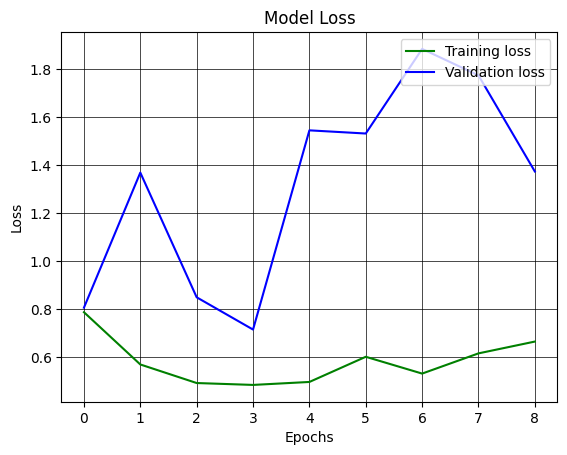

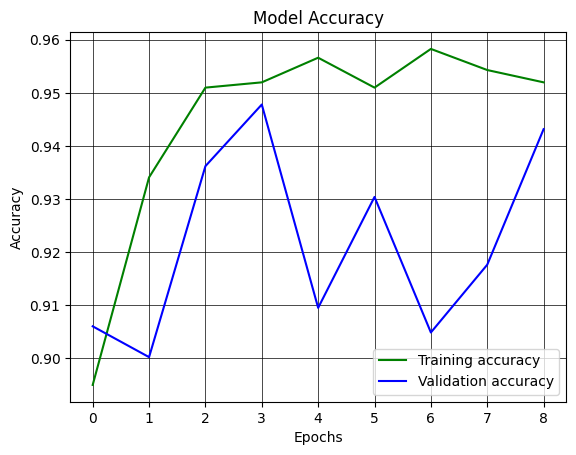

In [29]:
#Finding the maximum validation accuracy and its respective metrics
resnet152v2_max_val_acc = max(history.history['val_accuracy'])
resnet152v2_indices = [index for index, value in enumerate(history.history['val_accuracy']) if value == resnet152v2_max_val_acc]
resnet152v2_index_max_val_acc = resnet152v2_indices[0]
resnet152v2_max_training_loss = history.history['loss'][resnet152v2_index_max_val_acc]
resnet152v2_max_training_accuracy = history.history['accuracy'][resnet152v2_index_max_val_acc]
resnet152v2_max_validation_loss = history.history['val_loss'][resnet152v2_index_max_val_acc]

#Printing all metrics
print("Training Loss: ", resnet152v2_max_training_loss)
print("Training Accuracy: ", resnet152v2_max_training_accuracy)
print("Validation Loss: ", resnet152v2_max_validation_loss)
print("Validation Accuracy: ", resnet152v2_max_val_acc)

#Train loss vs validation loss graph
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#Train accuracy vs validation accuracy graph
plt.plot(history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### Evaluating the model with test data

In [30]:
evaluate_test_data = model.evaluate(test_set)
resnet152v2_test_loss = evaluate_test_data[0]
resnet152v2_test_acc = evaluate_test_data[1]

print("Testing loss: ", resnet152v2_test_loss)
print("Testing accuracy: ", resnet152v2_test_acc)

14/14 [==============================] - 4s 299ms/step - loss: 1.2332 - accuracy: 0.9443
Testing loss:  1.2332454919815063
Testing accuracy:  0.9443155527114868


### Loading, analyzing and predicting an image from test data


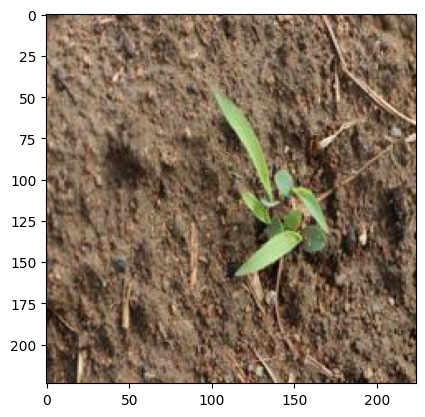

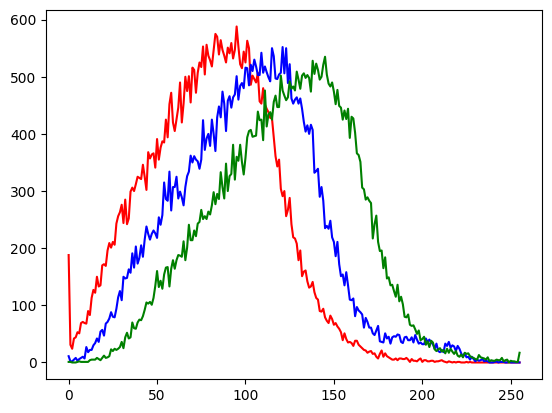

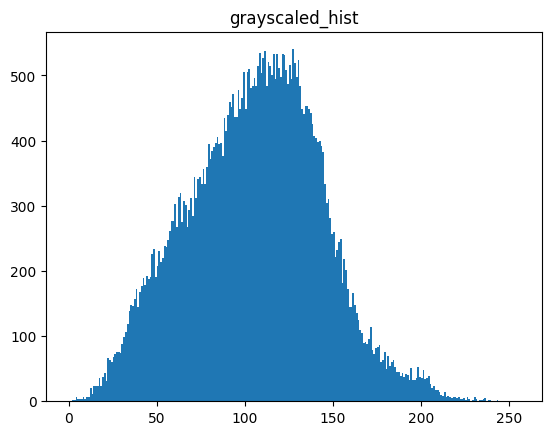

1/1 [==============================] - 4s 4s/step
Predicted class:  0
Sorghum


In [31]:
# Reading and displaying an image
img = load_img(single_image_path, target_size = (img_size,img_size))
plt.figure(1)
plt.imshow(img)

# Viewing the BGR histogram of the respective image
plt.figure(2)
cv2_img = cv2.imread(single_image_path)
color = {'b', 'g', 'r'}
for i, col in enumerate(color):
  histr = cv2.calcHist(images=[cv2_img],channels=[i],mask=None,histSize=[256], ranges=[0,256])
  plt.plot(histr, color=col)
plt.show()

# Viewing the gray-scaled histogram of the respective image
plt.figure(3)
img_grayscaled = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
plt.hist(img_grayscaled.ravel(), bins=256, range=[0,256])
plt.title('grayscaled_hist')
plt.show()

# Prediction of an image
input_arr = img_to_array(img)/255
input_arr = np.expand_dims(input_arr, axis = 0)
predictions = np.argmax(model.predict(input_arr), axis = -1)[0]
print("Predicted class: ", predictions)
print("Sorghum") if predictions == 0 else print("Grass weeds") if predictions == 1 else print("Broadleaf weeds")

### Predicting the classes of test data

In [32]:
# Declaring y_test
y_test= test_set.classes

# Finding the total number of test images
len_test_set = 0
for root, dirs, files in (os.walk(test_path)):
    for name in (files):
        len_test_set = len_test_set + 1

# Image prediction
y_pred = np.empty([len_test_set,1])
count = 0
for root, dirs, files in sorted(os.walk(test_path)):
    for name in sorted(files):
        img_path = os.path.join(root, name)
        img = load_img(img_path, target_size = (img_size,img_size))
        input_arr = img_to_array(img)/255
        input_arr = np.expand_dims(input_arr, axis = 0)
        y_pred[count] = np.argmax(model.predict(input_arr), axis = -1)[0]
        count = count + 1

1/1 [==============================] - 0s 32ms/step


### Generating classification report and confusion matrix for test data

CLASSIFICATION REPORT OF SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS
              precision    recall  f1-score   support

     class 0     0.8696    1.0000    0.9302       140
     class 1     0.9769    0.8639    0.9170       147
     class 2     1.0000    0.9722    0.9859       144

    accuracy                         0.9443       431
   macro avg     0.9488    0.9454    0.9444       431
weighted avg     0.9498    0.9443    0.9443       431



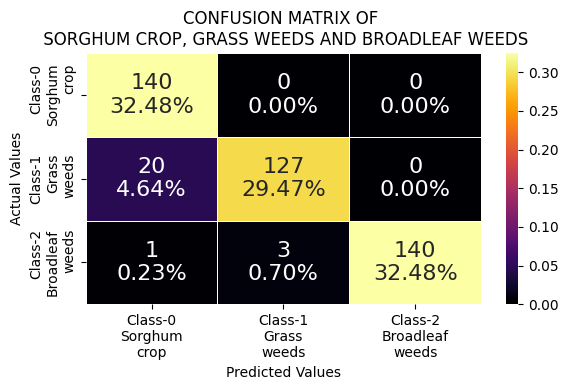

In [33]:
# Generating classification report
target_names = ['class 0', 'class 1', 'class 2']
print('CLASSIFICATION REPORT OF SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# Generating confusion matrix
cm_type = confusion_matrix(y_test, y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in cm_type.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm_type.flatten()/np.sum(cm_type)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(num_classes,num_classes)
figure = plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm_type/np.sum(cm_type), annot=labels, fmt='', cmap='inferno', annot_kws={"size": 16}, linecolor='white', linewidths=0.7)
ax.set_title('CONFUSION MATRIX OF \n SORGHUM CROP, GRASS WEEDS AND BROADLEAF WEEDS')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
ax.xaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
ax.yaxis.set_ticklabels(['Class-0\nSorghum\ncrop','Class-1\nGrass\nweeds','Class-2\nBroadleaf\nweeds'])
plt.tight_layout()
plt.show()

<center> <h2> <b> Comparision graphs for accuracy and loss of </br> VGG19, DENSENET201, MOBILENETV2, and RESNET152V2</b> </h2> </center>

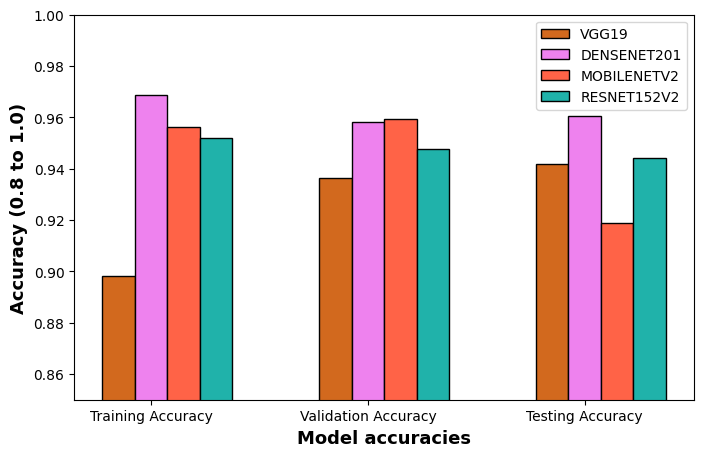

In [34]:
# Plotting Training/Validation/Testing Accuraccies

# Set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(8, 5))

# Set height of bar
vgg19 = [vgg19_max_training_accuracy, vgg19_max_val_acc, vgg19_test_acc]
densenet201 = [densenet201_max_training_accuracy, densenet201_max_val_acc, densenet201_test_acc]
mobilenetv2 = [mobilenetv2_max_training_accuracy, mobilenetv2_max_val_acc, mobilenetv2_test_acc]
resnet152v2 = [resnet152v2_max_training_accuracy, resnet152v2_max_val_acc, resnet152v2_test_acc]

# Set position of bar on X axis
br1 = np.arange(len(vgg19))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, vgg19, color ='chocolate', width = barWidth, edgecolor ='black', label ='VGG19')
plt.bar(br2, densenet201, color ='violet', width = barWidth, edgecolor ='black', label ='DENSENET201')
plt.bar(br3, mobilenetv2, color ='tomato', width = barWidth, edgecolor ='black', label ='MOBILENETV2')
plt.bar(br4, resnet152v2, color ='lightseagreen', width = barWidth, edgecolor ='black', label ='RESNET152V2')

# Adding Xticks
plt.xlabel('Model accuracies', fontweight ='bold', fontsize = 13)
plt.ylabel('Accuracy (0.8 to 1.0)', fontweight ='bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(vgg19))],
		['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy'])
plt.ylim(0.85, 1.0)
plt.legend()
plt.show()


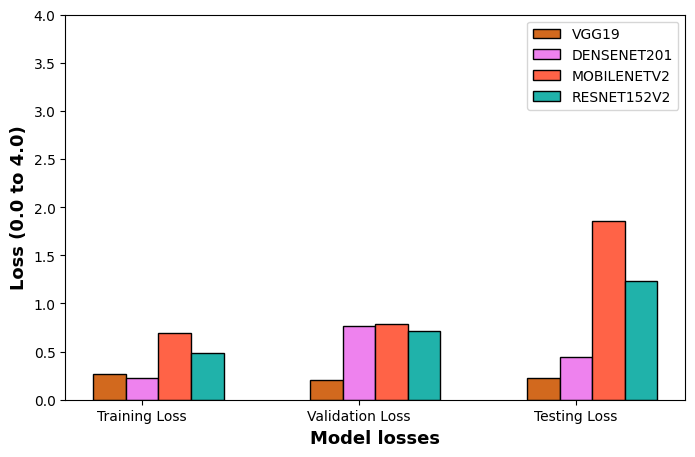

In [35]:
# Plotting Training/Validation/Testing Losses

# Set width of bar
barWidth = 0.15
fig = plt.subplots(figsize =(8, 5))

# Set height of bar
vgg19 = [vgg19_max_training_loss, vgg19_max_validation_loss, vgg19_test_loss]
densenet201 = [densenet201_max_training_loss, densenet201_max_validation_loss, densenet201_test_loss]
mobilenetv2 = [mobilenetv2_max_training_loss, mobilenetv2_max_validation_loss, mobilenetv2_test_loss]
resnet152v2 = [resnet152v2_max_training_loss, resnet152v2_max_validation_loss, resnet152v2_test_loss]

# Set position of bar on X axis
br1 = np.arange(len(vgg19))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

# Make the plot
plt.bar(br1, vgg19, color ='chocolate', width = barWidth, edgecolor ='black', label ='VGG19')
plt.bar(br2, densenet201, color ='violet', width = barWidth, edgecolor ='black', label ='DENSENET201')
plt.bar(br3, mobilenetv2, color ='tomato', width = barWidth, edgecolor ='black', label ='MOBILENETV2')
plt.bar(br4, resnet152v2, color ='lightseagreen', width = barWidth, edgecolor ='black', label ='RESNET152V2')

# Adding Xticks
plt.xlabel('Model losses', fontweight ='bold', fontsize = 13)
plt.ylabel('Loss (0.0 to 4.0)', fontweight ='bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(vgg19))],
		['Training Loss', 'Validation Loss', 'Testing Loss'])
plt.ylim(0.0, 4.0)
plt.legend()
plt.show()
